# Dicom Attributes

Load DWI images from different sources

In [1]:
from itertools import combinations
import re
from glob import glob
from os.path import join
from typing import List, Optional
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import numpy as np
from scipy.stats import scoreatpercentile
import xarray as xr
import pydicom as dcm
from pydicom.datadict import keyword_for_tag

from mriqa.dcmio import diffusion_bvalue, slice_location, matrix_yx, software_versions, manufacturer
from dcmfetch import fetch_series

In [2]:
test_data_dir = join('..', '..', 'tests', 'test-data', 'diffusion')
def read_series(path, globspec='*.dcm'):
    return [dcm.dcmread(f) for f in glob(join(path, globspec))]

### Multiframes
Ideally, we'd like a generic mapping from multiframe to xarray but this is complicated by the fact that some frames are directional and some isotropic. We could start with an unopinionated version and then specialise to something that knows about diffusion.

For Philips:
```
MRDiffusionSequence[0]

b0:
    - Diffusion Directionality = 'NONE'
    - Diffusion b-value = 0.0

directional images:
    - Diffusion Directionality = 'DIRECTIONAL'
    - Diffusion b-value > 0.0
    - Diffusion Gradient Orientation = [0, 0, -1], [-1, 0, 0], [0, 1, 0]

trace images:
    - Diffusion Directionality = 'ISOTROPIC'
    - Diffusion b-value > 0.0
```


OK, could massage this a bit further by changing the gradient orientation to something like x, y, z, iso. Need specific trap for the missing direction fields. Could also drop the stack dimension. Could also split into directional and isotropic parts. God knows where the adc map (if any) went. Might be better to do a reverse lookup in the dict to get the coordinate names as they'll be more python friendly (though this may not work for private tags..)

In [3]:
def _index_label(dimindex: dcm.Dataset) -> str:
    """
    Get a label for an index based on the tag or on the DimensionDescriptionLabel
    """
    index_ptr = dimindex.DimensionIndexPointer
    # Returns empty string if tag not in dict
    label = keyword_for_tag(index_ptr)
    if not label:
        # Philips put in a Label whereas Siemens don't seem to. May need more thought on mapping to variable name
        if 'DimensionDescriptionLabel' in dimindex:
            label = re.sub(r'\W+|^(?=\d)', '_', dimindex.DimensionDescriptionLabel)
        else:
            label = str(index_ptr)
    return label

def mf_to_xa(dobj: dcm.Dataset) -> xr.DataArray:
    """
    "Un-opinionated" mapping from a dicom (diffusion) multiframe to an xr dataarray
    """
    # The image data in frame order - will have dims: nframes * ny * nx
    mfdata = dobj.pixel_array & (2**dobj.BitsStored - 1)

    # We can get the axes labels and the info to extract the values from the DimensionIndexSequence
    # Each one corresponds to an index DimensionIndexValues
    # From these pointers and the indices in the frames we can get the values
    # The accessors are closures to access these
    labels = [_index_label(dimindex) for dimindex in dobj.DimensionIndexSequence]
    fgpointers = [dimindex.FunctionalGroupPointer for dimindex in dobj.DimensionIndexSequence]
    indexpointers = [dimindex.DimensionIndexPointer for dimindex in dobj.DimensionIndexSequence]
    accessors = [
        lambda pffg, index, fgp=fgp, ip=ip: pffg[fgp][0][ip].value if ip in pffg[fgp][0] else index
        for fgp, ip in zip(fgpointers, indexpointers)
    ]

    # Check range of indices
    pffgs = dobj.PerFrameFunctionalGroupsSequence
    all_indices = np.array([
        pffg.FrameContentSequence[0].DimensionIndexValues for pffg in pffgs
    ], dtype=int).T
    index_vectors = [sorted(set(indices)) for indices in all_indices]
    index_lengths = [len(index_vector) for index_vector in index_vectors]
    dims = tuple(index_lengths)
    xadata = np.empty(dims + mfdata.shape[-2:], dtype=mfdata.dtype)

    # Want list of arrays of coords
    indices = pffgs[0].FrameContentSequence[0].DimensionIndexValues
    dtypes = []
    for accessor, index in zip(accessors, indices):
        dtypes.append(type(accessor(pffgs[0], index)))    
    coords = [np.empty(dim, dtype=dtype) for (dim, dtype) in zip(dims, dtypes)]

    for frame, pffg in enumerate(pffgs):
        indices = pffg.FrameContentSequence[0].DimensionIndexValues
        np_indices = tuple([
            index_vector.index(i) for index_vector, i in zip(index_vectors, indices)
        ])
        xadata[np_indices] = mfdata[frame]
        for i, (accessor, index) in enumerate(zip(accessors, indices)):
            coords[i][np_indices[i]] = accessor(pffg, index)

    ny, nx = xadata.shape[-2:]
    return xr.DataArray(
        xadata,
        dims=labels + ['y', 'x'],
        coords={
            label: (label, coord_vector)
            for (label, coord_vector) in zip(labels+['y', 'x'], coords + [range(ny), range(nx)]) # is this sensitive to original order?
        }
    )

### Philips Multiframe

In [4]:
def isotropic_index(pffgs:dcm.Sequence, index_loc:int=3) -> int:
    """
    Get the index value that corresponds to (isotropic) trace images (can we do this without specifying the index position?)
    """
    indices = set()
    for pffg in pffgs:
        diffn = pffg.MRDiffusionSequence[0]
        if 'DiffusionDirectionality' in diffn:
            if diffn.DiffusionDirectionality in ('NONE', 'ISOTROPIC'):
                indices.add(pffg.FrameContentSequence[0].DimensionIndexValues[index_loc])
    assert len(indices) == 1
    (index,) = indices
    return index


def diffn_iso_mframe_to_da(dobj: dcm.Dataset) -> xr.DataArray:
    # Get DataArray corresponding to "isotropic" frames
    index_of_iso_frames = isotropic_index(dobj.PerFrameFunctionalGroupsSequence)
    return mf_to_xa(dobj).loc[{
        'DiffusionGradientOrientation': index_of_iso_frames,
        'StackID': '1'
    }].drop([
        'DiffusionGradientOrientation', 'StackID'
    ]).rename({
        'InStackPositionNumber': 'z',
        'DiffusionBValue': 'bval'
    })


def diffn_adc_mframe_to_da(dobj: dcm.Dataset) -> xr.DataArray:
    # Get DataArray corresponding to calculated ADC frames
    # WIP: need to find a philips example with ADC images
    # This may need modification
    index_of_iso_frames = isotropic_index(dobj.PerFrameFunctionalGroupsSequence)
    return mf_to_xa(dobj).loc[{
        'DiffusionGradientOrientation': index_of_iso_frames,
        'StackID': '1'
    }].drop([
        'DiffusionGradientOrientation', 'StackID'
    ]).rename({
        'InStackPositionNumber': 'z',
        'DiffusionBValue': 'bval'
    })


def diffn_mframes_to_ds(trace_dobj: dcm.Dataset, adc_dobj: Optional[dcm.Dataset]=None) -> xr.Dataset:
    traces = diffn_iso_mframe_to_da(trace_dobj)
    if adc_dobj is not None:
        adcs = diffn_adc_mframe_to_da(adc_dobj)
        ds = xr.Dataset({
            'trace': traces,
            'manufacturer_adc': adcs
        })
    else:
        ds = xr.Dataset({
            'trace': traces,
        })

    ds.attrs['manufacturer'] = manufacturer(trace_dobj)
    ds.attrs['software_version'] = software_versions(trace_dobj)
    return ds

### Siemens XA hybrid

In [5]:
def diffn_hybrid_to_ds(trace_dobjs: List[dcm.Dataset], adc_dobjs:Optional[List[dcm.Dataset]]=None) -> xr.Dataset:
    trace_dobjs = sorted(trace_dobjs, key=lambda d: diffusion_bvalue(d, frame=0))
    trace_xas = [
        mf_to_xa(dobj).loc[{'StackID': '1', 'TemporalPositionIndex': 1}].drop(['StackID', 'TemporalPositionIndex'])
        for dobj in trace_dobjs
    ]
    bvals = [diffusion_bvalue(d, frame=0) for d in trace_dobjs]  
    traces = xr.concat(trace_xas, 'bval').assign_coords(bval=bvals).rename({
        'InStackPositionNumber': 'z',
    })
    
    if adc_dobjs is not None:
        adcs = [
            mf_to_xa(dobj).loc[{'StackID': '1', 'TemporalPositionIndex': 1}].drop(['StackID', 'TemporalPositionIndex'])
            for dobj in adc_dobjs
        ]        
        adc = adcs[0].rename({
            'InStackPositionNumber': 'z',
        })
        ds = xr.Dataset({
            'trace': traces,
            'manufacturer_adc': adc
        })
    else:
        ds = xr.Dataset({
            'trace': traces,
        })

    ds.attrs['manufacturer'] = manufacturer(trace_dobjs[0])
    ds.attrs['software_version'] = software_versions(trace_dobjs[0])
    return ds

### Siemens VE and GE Single Frames

In [6]:
def diffn_series_to_ds(trace_dobjs: List[dcm.Dataset], adc_dobjs:Optional[List[dcm.Dataset]]=None) -> xr.Dataset:
    trace_dobjs = sorted(trace_dobjs, key=lambda d: (diffusion_bvalue(d), slice_location(d)))

    nbvals = len(set(diffusion_bvalue(d) for d in trace_dobjs))
    nz =  len(trace_dobjs) // nbvals
    bvals = [diffusion_bvalue(d) for d in trace_dobjs[::nz]]
    z = [slice_location(d) for d in trace_dobjs[:nz]]
    ny, nx = matrix_yx(trace_dobjs[0])

    traces = xr.DataArray(
        np.array([d.pixel_array & (2**d.BitsStored - 1) for d in trace_dobjs], dtype=float).reshape(nbvals, nz, ny, nx),
        dims=('bval', 'z', 'y', 'x'),
        coords={
            'bval': ('bval', bvals, {'units': 'sec/mm2'}),
            'z': ('z', z, {'units': 'mm'})
        },
        name='bval_imgs'
    )

    if adc_dobjs is not None:
        adc_dobjs = sorted(adc_dobjs, key=slice_location)
        z = [slice_location(d) for d in adc_dobjs]
        adcs = xr.DataArray(
            np.array([d.pixel_array & (2**d.BitsStored - 1) for d in adc_dobjs], dtype=float),
            dims=('z', 'y', 'x'),
            coords={'z': z},
            name='manufacturer_adc',
            attrs={
                'units':'um2/sec'
            }
        )

        ds = xr.Dataset({
            'trace': traces,
            'manufacturer_adc': adcs
        })
    else:
        ds = xr.Dataset({
            'trace': traces,
        })

    ds.attrs['manufacturer'] = manufacturer(trace_dobjs[0])
    ds.attrs['software_version'] = software_versions(trace_dobjs[0])
    return ds        

In [7]:
def diffn_to_ds(trace_dobjs: List[dcm.Dataset], adc_dobjs:Optional[List[dcm.Dataset]]=None) -> xr.Dataset:
    manufact = manufacturer(trace_dobjs[0])
    is_mf = is_multiframe(trace_dobjs[0])
    print(manufact, is_mf)
    if manufact == 'Philips' and is_mf and len(trace_dobjs) == 1:
        return diffn_mframes_to_ds(trace_dobjs[0], adc_dobjs[0] if adc_dobjs else None)
    elif manufact == 'Siemens' and is_mf:
        return diffn_hybrid_to_ds(trace_dobjs, adc_dobjs)
    elif manufact in ['Siemens', 'GE'] and not is_mf:
        return diffn_series_to_ds(trace_dobjs, adc_dobjs)
    else:
        raise ValueError(f'diffn_to_ds: unable to extract {manufact} {"multiframe" if is_mf else "series"}')

### Plotting Routines Based on xr.Dataset

In [8]:
def trace_plot(ds: xr.Dataset, sliceno: int):
    traces = ds.trace[{'z': sliceno}]
    vmax = traces.max()
    nplots = len(traces.coords['bval'])
    ncols = 2
    nrows = int(np.ceil(nplots / ncols))
    fig, axs = plt.subplots(nrows, ncols, constrained_layout=True, figsize=(4 * ncols, 4 * nrows)) 
    for ax, bval in zip(axs.flat, traces.coords['bval']):
        img = ax.imshow(traces.loc[bval], norm=LogNorm(vmax=vmax), cmap='bone')
        ax.axis(False)
        ax.set_title(f'b={int(bval)}', fontsize=14)
    for ax in axs.flat[nplots:]:
        ax.axis(False)

    fig.colorbar(img, ax=axs.tolist(), label='Brightness (log)', shrink=0.75)
    fig.suptitle('Trace Images (Log Scale)', fontsize=16)

def adc_plot(ds: xr.Dataset, sliceno: int):
    adc = ds.manufacturer_adc[{'z': sliceno}]
    vmax = adc.max()
    fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(5, 5))
    img = ax.imshow(adc, norm=LogNorm(vmax=vmax), cmap='bone')
    ax.axis(False)
    fig.colorbar(img, ax=ax, label='ADC (log)', shrink=0.75)
    ax.set_title('ADC', fontsize=14)

### Siemens VE11C (Single Frames)

In [9]:
# VE11C
trace_series, adc_series = 8, 9
#traces = fetch_series('PQA20200127EXPRISMA', '6', sernos=trace_series)
#adcs = fetch_series('PQA20200127EXPRISMA', '6', sernos=adc_series)
traces = read_series(join(test_data_dir, 'siemens_ve', 'dicom', 'traces'))
adcs = read_series(join(test_data_dir, 'siemens_ve', 'dicom', 'adc'))
ds = diffn_series_to_ds(trace_dobjs=traces, adc_dobjs=adcs)

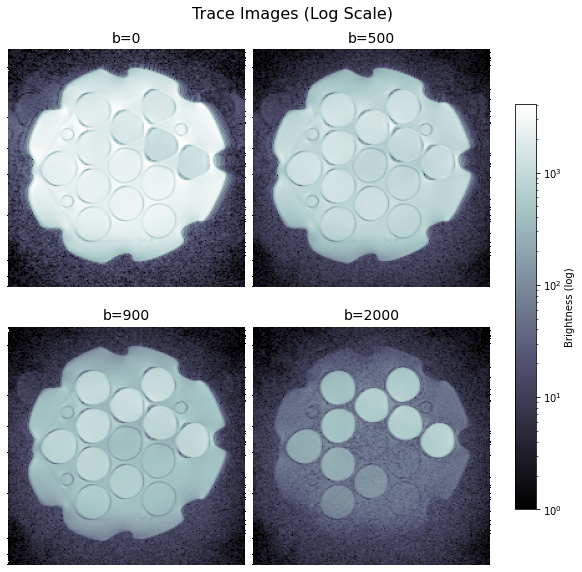

In [10]:
trace_plot(ds, 10)

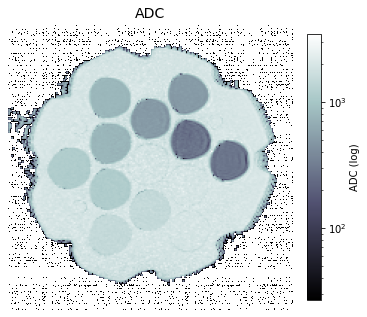

In [11]:
adc_plot(ds, 10)

### GE (Single Frames)

In [12]:
# GE
trace_series, adc_series = 28, 2800
#traces = fetch_series('PQA20200202NBTMR11PROSTATE', '7935', sernos=trace_series)
#adcs = fetch_series('PQA20200202NBTMR11PROSTATE', '7935', sernos=adc_series)
traces = read_series(join(test_data_dir, 'ge_1', 'dicom', 'traces'))
adcs = read_series(join(test_data_dir, 'ge_1', 'dicom', 'adc'))
ds = diffn_series_to_ds(trace_dobjs=traces, adc_dobjs=adcs)

In [13]:
trace_plot(ds, 10)

In [14]:
adc_plot(ds, 10)

### Philips (Single Multiframe)
Can't seem to find any adc images

In [15]:
trace_series, adc_series = 2101, None
#dobjs = fetch_series('PQA20200121NBTMR12PROSTATE', '632574422', sernos=trace_series, imagesonly=True)
traces = read_series(join(test_data_dir, 'philips_1', 'dicom', 'traces'))
ds = diffn_mframes_to_ds(traces[0])

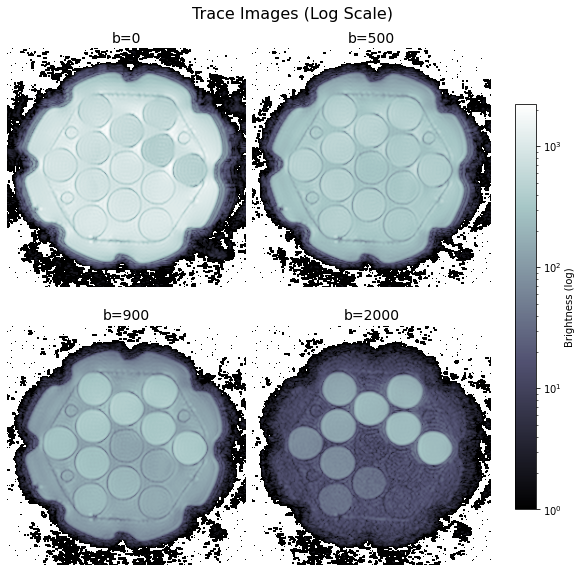

In [16]:
trace_plot(ds, 10)

### Siemens XA (Multiple Multiframes)

In [17]:
trace_series, adc_series = 14, 15
#traces = fetch_series('PQA20200926GWHSOLAPROSTATE', '4ed13231-a273-40', sernos=trace_series)
#adcs = fetch_series('PQA20200926GWHSOLAPROSTATE', '4ed13231-a273-40', sernos=adc_series)
traces = read_series(join(test_data_dir, 'siemens_xa', 'dicom', 'traces'))
adcs = read_series(join(test_data_dir, 'siemens_xa', 'dicom', 'adc'))

Each dicom object seems to be a multiframe with 3 dimensions: both StackID and TemporalPositionIndex are singletons, InStackPositionNumber is the sliceno. Multiple dicom objects have different bvals.

In [18]:
ds = diffn_hybrid_to_ds(traces, adcs)

In [19]:
trace_plot(ds, 10)

In [20]:
adc_plot(ds, 10)

### TODO

- Find examples of Philips with adcs in same multiframe as it is suggested may sometimes be the case
- Decide whether we want coords in z, y, x to be in mm from isocentre or just indices
  - currently base one indices in multiframes and slice position in mm in single frame series
